# Engine power vs emissions

Click {fa}`rocket` --> {guilabel}`Live Code` to activate live coding on this page!




## Problem
In this problem we're trying to optimize a diesel engine for maximum power and minimum CO<sub>2</sub> emissions. Depending on the optimal engine speed, the power and CO<sub>2</sub> emmisions change.

The following data is available:

| RPM  | CO<sub>2</sub> Emissions | Power   |
|------|---------------|---------|
| 800  | 708.       | 161.141 |
| 1000 | 696.889       | 263.243 |
| 1200 | 688.247       | 330.51 |
| 1400 | 682.897       | 381.561 |
| 1700 | 684.955       | 391.17 |
| 1800 | 697.3       | 370. |

This data is interpolated to obtain a continuous relation:

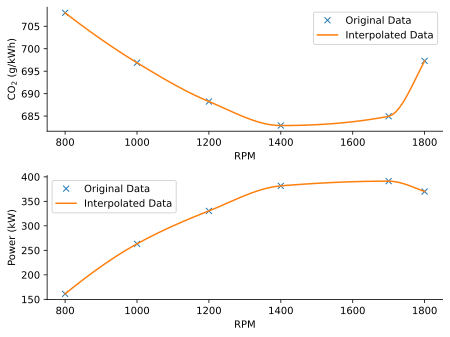

In [44]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

RPM = np.array([800, 1000, 1200, 1400, 1700, 1800])
CO2 = np.array([708, 696.889, 688.247, 682.897, 684.955, 697.3 ])
POW = np.array([161.141, 263.243, 330.51 , 381.561, 391.17, 370 ])

def CO2func(s):
    return sp.interpolate.pchip_interpolate(RPM,CO2,s)

def POWfunc(s):
    return sp.interpolate.pchip_interpolate(RPM,POW,s)

RPM_continuous = np.linspace(800,1800,100)
plt.figure()
plt.subplot(2,1,1)
plt.plot(RPM, CO2, 'x', label='Original Data')
plt.plot(RPM_continuous, CO2func(RPM_continuous), label='Interpolated Data')
plt.xlabel('RPM')
plt.ylabel('CO$_2$ (g/kWh)')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
plt.legend()

plt.subplot(2,1,2)
plt.plot(RPM, POW, 'x', label='Original Data')
plt.plot(RPM_continuous, POWfunc(RPM_continuous), label='Interpolated Data')
plt.xlabel('RPM')
plt.ylabel('Power (kW)')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
plt.legend();


```{figure} ./figures/CO2_power.svg
:name: RPM-CO2_power
:width: 600px
Interpolation of CO<sub>2</sub> emissions and Power
```

## Model

Let's define our model in three different ways, as defined in {eq}`multi_objective_optimization_weighted`, {eq}`multi_objective_optimization_goal` and {eq}`multi_objective_optimization_pareto`.

We'll define the model as follows:
- Design variables: width, height and depth of a block
- Objective function: minimum volume of the block
- Inequality constraint functions: minimum surface area of each face of $0.8$ $\text{m}^2$ and maximum weight of $3000$ $\text{kg}$
- Equality constraint functions: none
- Bounds: positive dimensions

### Design variables
Let's start with our design variables. In this case a logical choice could be the width, height and depth of our block

```{math}
:label: nonlinear_constrained_optimization_x
x=\left[ \begin{matrix}
   {{x}_{width}}  \\
   {{x}_{depth}}  \\
   {{x}_{height}}  \\
\end{matrix} \right]=\left[ \begin{matrix}
   {{x}_{1}}  \\
   {{x}_{2}}  \\
   {{x}_{3}}  \\
\end{matrix} \right]
```

### Objective function
Now we can define the objective function as the product of the dimension to represent $\mathop {\min }\limits_x f\left(x\right) $ in {eq}`nonlinear_constrained_optimization`:

```{math}
:label: nonlinear_constrained_optimization_f
{\min }\limits_x f\left(x\right) = x_1 \cdot x_2 \cdot x_3
```

### Inequality constraints

Let's continue with the inequality constraints, which should deal with the required positive dimensions, minimum surface area of each face of $0.8$ $\text{m}^2$ and maximum weight of $3000$ $\text{kg}$. These can be defined in the form ${{g}}\left(x_{ij}\right) \le 0$ as:

```{math}
:label: nonlinear_constrained_optimization_g
g_1\left(x\right) = -x_{1} \cdot x_2 + 0.8 \\
g_2\left(x\right) = -x_{2} \cdot x_3 + 0.8 \\
g_3\left(x\right) = -x_{1} \cdot x_3 + 0.8 \\
g_4\left(x\right) = -x_{1} \cdot x_2 \cdot x_3 \cdot 2500 + 3000 \\
```


:::{card} Test yourself

<iframe src="https://tudelft.h5p.com/content/1292254701363993127/embed" aria-label="upper lower equal or bigger" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>

:::

### Bounds

The dimensions of the block cannot be negative. Therefore, the bounds can be defined as:

```{math}
:label: bounds_nonlinear
0<{{x}_{i}}\text{   } i=1,2,3
```

### Find best solution manually

:::{card} Test yourself
Try and adjust the values for $x_1$, $x_2$ and $x_3$. Can you find the optimal solution?
<iframe src="../_static/block.html" style="overflow:hidden;height:350;width:100%" height="350" width="100%"> frameborder="0"></iframe>
:::

## Method

Now let's solve this problem using an optimization method.

### Import libraries

In [ ]:
import scipy as sp
import numpy as np

In [1]:
import scipy as sp 
import numpy as np

### Define variables
As before, we don't need to specify our variable $x$ itself as defined in {eq}`nonlinear_constrained_optimization_x`. However, this optimization method requires an initial guess. An arbitrary value is chosen here:

In [13]:
x0 = np.array([5,0,1])

### Define objective function

The objective function was defined in {eq}`nonlinear_constrained_optimization_f`, which gives:

In [14]:
def func(x):
    vol = x[0]*x[1]*x[2]
    return vol

### Define constrain functions

The constraint functions were defined in {eq}`nonlinear_constrained_optimization_g`. We had no equality constraints. Unlike before with {ref}`the method to solve linear constrained problem <linear_constraint_function_method>`, we need an object which defines the upper and lower bounds. As this problem has only an upper bound of $0$, the lower bound is set to $\infty$ which is `np.inf` in python. Note that a single constraint object can include multiple constraints.

In [15]:
def nonlinconfun(x):
    c1 = 0.8 - x[0]*x[1]
    c2 = 0.8 - x[0]*x[2]
    c3 = 0.8 - x[1]*x[2]
    c4 = 3000 - 2500 * x[0] * x[1] * x[2]
    return np.array([c1,c2,c3,c4])

cons = sp.optimize.NonlinearConstraint(nonlinconfun, np.array([-np.inf,-np.inf,-np.inf,-np.inf]), np.array([0,0,0,0]))

### Define bounds
The bounds were defined in {eq}`bounds_nonlinear` and result in:

In [16]:
bounds = [[0, None],
          [0, None],
          [0, None]]

### Solve the problem

Now let's solve the problem. The `cons` object can be added directly, in the case of equality constraints as well you can define a list of constrainer objects as an input.

In [17]:
result = sp.optimize.minimize(fun = func,x0 = x0,bounds = bounds,constraints=cons)
print(result)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.2000000000024624
       x: [ 1.353e+00  1.488e+00  5.962e-01]
     nit: 10
     jac: [ 8.871e-01  8.065e-01  2.013e+00]
    nfev: 41
    njev: 10


## Exercise

:::{card} Test yourself
Click {fa}`rocket` --> {guilabel}`Live Code` to activate live coding on this page.
<iframe src="https://tudelft.h5p.com/content/1292254715005702697/embed" aria-label="apply" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
:::

## Questions, discussions and comments
<script src="https://utteranc.es/client.js"
        repo="TeachBooks/engineering-systems-optimization"
        issue-term="title"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>